# Сегментация клиентов банка по потреблению

**Цель работы** - сегментировать клиентов банка по количеству потребляемых продуктов, чтобы лучше понять потребности клиентов, и на основе сегментации принимать решения, какие продукты предлагать.

**Задачи работы:**

1. Провести исследовательский анализ данных;
2. Сегментировать клиентов банка по количеству потребляемых продуктов;
3. Сформулировать и проверить статистические гипотезы.

- Презентация по итогу работы: https://drive.google.com/file/d/1hqh1Jx8nXNtucyMVF3dFmd_lGiC3JkXe/view?usp=sharing

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Сегментация-клиентов-банка-по-потреблению" data-toc-modified-id="Сегментация-клиентов-банка-по-потреблению-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сегментация клиентов банка по потреблению</a></span></li><li><span><a href="#Проверка-статистических-гипотез" data-toc-modified-id="Проверка-статистических-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка статистических гипотез</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li>  
    

## Предобработка данных

Изучим исходные данные, проверим на пропуски и дубликаты, а также соответствие типам данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from scipy import stats as st

pd.options.display.float_format = '{:,.1f}'.format
sns.set(font_scale=1.1)

In [2]:
#откроем файл с исходными данными
df = pd.read_csv('datasets/bank_dataset.csv')

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [3]:
print("База данных содержит {} наблюдений (клиенты) и {} столбцов (атрибуты).".format(df.shape[0],df.shape[1]))
print("Пропущенных значений в каждом столбце :\n{}".format(df.isna().mean()))
print("Типы данных в столбцах:\n{}".format(df.dtypes))

База данных содержит 10000 наблюдений (клиенты) и 12 столбцов (атрибуты).
Пропущенных значений в каждом столбце :
userid             0.0
score              0.0
City               0.0
Gender             0.0
Age                0.0
Objects            0.0
Balance            0.4
Products           0.0
CreditCard         0.0
Loyalty            0.0
estimated_salary   0.0
Churn              0.0
dtype: float64
Типы данных в столбцах:
userid                int64
score                 int64
City                 object
Gender               object
Age                   int64
Objects               int64
Balance             float64
Products              int64
CreditCard            int64
Loyalty               int64
estimated_salary    float64
Churn                 int64
dtype: object


В исходном датасете 11 признаков клиентов банка, из них 2 категориальных, остальные - числовые. 

В одном из столбцов, содержащем информацию о балансе на счете, много пропущенных значений - 36%.

Названия колонок в исходном файле оформлены в разном стиле. С типами данных всё в порядке.

In [4]:
# приведем названия колонок к нижнему регистру
df.columns = df.columns.str.lower()

Разберемся с пропусками в столбце с балансом на счете. Рассмотрим, что это за пропуски и активные ли это клиенты.


In [5]:
# заменим пропуски
unknown_balance = df.fillna('unknown')
unknown_balance[unknown_balance['balance'] == 'unknown']['loyalty'].value_counts()

1    1873
0    1744
Name: loyalty, dtype: int64

Примерно половина клиентов активная, остальная - нет.


В основном датасете не будем пока заполнять пропуски, пока проводим исследование данных, чтобы не искажать результаты.

Изучим также, не попали ли данные клиенты в отток.

In [6]:
unknown_balance[unknown_balance['balance'] == 'unknown']['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Большая часть клиентов, у которых неизвестен баланс на счете, ушла. Возможно, что это клиенты, которые пользовались кредитным продуктом банка, и ушли, когда выплатили кредит.

Изучим также, сколькими продуктами пользуются клиенты, у которых неизвестен баланс на счете.

In [7]:
unknown_balance[unknown_balance['balance'] == 'unknown']['products'].value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

Выведем распределение клиентов по количеству потребляемых продуктов для всего датасета для сравнения

In [8]:
df.groupby('products').agg('count')

,userid,score,city,gender,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,,,
1,5084,5084,5084,5084,5084,5084,4179,5084,5084,5084,5084
2,4590,4590,4590,4590,4590,4590,1990,4590,4590,4590,4590
3,266,266,266,266,266,266,168,266,266,266,266
4,60,60,60,60,60,60,46,60,60,60,60


Отметим, что в отличие от всего датасета клиенты, у которых неизвестен баланс на счете, в основном пользуются 2 продуктами.

Проверим, сколько и каковы возможные (уникальные) значения в каждом категориальном столбце.

In [9]:
print("Уникальные значения в каждом категориальном столбце:")
for col in df.select_dtypes(include=[object]):
    print(col,":", df[col].unique())

Уникальные значения в каждом категориальном столбце:
city : ['Ярославль' 'Рыбинск' 'Ростов Великий']
gender : ['Ж' 'М']


Проверим датасет на дубликаты

In [10]:
print('Число полных дубликатов в таблице:', df.duplicated().sum())
print('Число уникальных клиентов', df['userid'].nunique())

Число полных дубликатов в таблице: 0
Число уникальных клиентов 10000


Клиенты в таблице не повторяются.

**Вывод**

На этапе предобработки данных мы изучили данные из файлов, привели названия столбцов таблиц к одному стилю.

Располагаем данными о 10000 клиентах банка «Метанпром». C типами данных по столбцам всё в порядке, пропущенные значения есть только в столбце *Balance* - баланс на счёте, пропусков довольно много, заполнять мы их будем после того, как проведем исследование данных, чтобы не искажать результаты.

Однако, мы изучили особенности клиентов, у которых неизвестен баланс на счете, и узнали, что они в отличие от основного датасета в основном пользуются 2 продуктами. При этом большая часть клиентов, у которых неизвестен баланс на счете, ушла. Возможно, что это клиенты, которые пользовались кредитным продуктом банка, и ушли, когда выплатили кредит.


## Исследовательский анализ данных

На данном этапе проведем:

1. анализ признаков клиентов банка с помощью построения диаграмм, изучение средних значений и стандартных отклонений;
2. выявление аномалий в данных;
3. составление усредненного портрета клиента банка;
4. выявление особенностей групп клиентов по количеству потребляемых продуктов;
4. анализ зависимости количества потребляемых продуктов от других признаков (например, зарплаты клиента, возраста и т.п.).


**Анализ признаков клиентов банка**

In [11]:
#оценим интервалы значений для небинарных признаков
df[['score', 'age', 'objects', 'balance', 'products', 'estimated_salary']].describe()

,score,age,objects,balance,products,estimated_salary
count,"10,000.0","10,000.0","10,000.0","6,383.0","10,000.0","10,000.0"
mean,650.5,38.9,5.0,"119,827.5",1.5,"100,090.2"
std,96.7,10.5,2.9,"30,095.1",0.6,"57,510.5"
min,350.0,18.0,0.0,"3,768.7",1.0,11.6
25%,584.0,32.0,3.0,"100,182.0",1.0,"51,002.1"
50%,652.0,37.0,5.0,"119,839.7",1.0,"100,193.9"
75%,718.0,44.0,7.0,"139,512.3",2.0,"149,388.2"
max,850.0,92.0,10.0,"250,898.1",4.0,"199,992.5"


Вопросы вызывает только столбец с зарплатой клиентов, поскольку стандартное отклонение составляет 57 510,5 и минимальная зарплата - 11,6.

Т.к. нас интересует сегментация по количеству потребляемых продуктов клиентами банка, рассмотрим столбец с количеством продуктов подробнее.

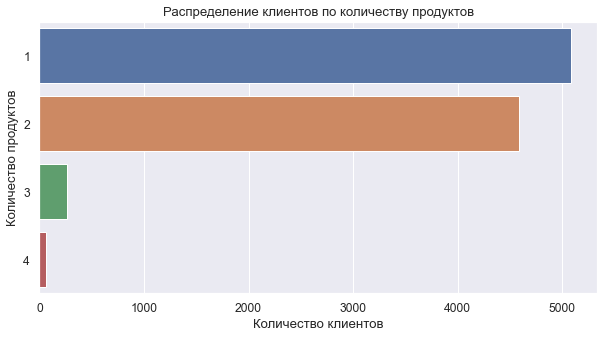

In [12]:
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'products' , data = df)
plt.title("Распределение клиентов по количеству продуктов")
plt.xlabel('Количество клиентов')
plt.ylabel('Количество продуктов')
plt.show()

Изучим подробнее разделение клиентов по количеству продуктов, узнаем, есть ли аномалии

**Выявление аномалий в данных**

In [13]:
df['products'].median()

1.0

75% клиентов пользуются не менее чем 2 продуктами, но есть и такие клиенты, которые пользуются 4 продуктами. При этом в среднем всё же клиенты банка пользуются 1 продуктом.

In [14]:
# Посчитаем 95-й и 99-й перцентили количества продуктов, используемых клиентами
print(np.percentile(df['products'], [90, 95, 99]))

[2. 2. 3.]


Не более 5% пользователей пользуются 2 продуктами, и только 1% пользователей - больше 3 продуктов.

**Составление усредненного портрета клиента банка**

Для анализа распределения признаков клиентов построим:

столбчатые диаграммы для бинарных значений признаков, боксплоты для непрерывных переменных.

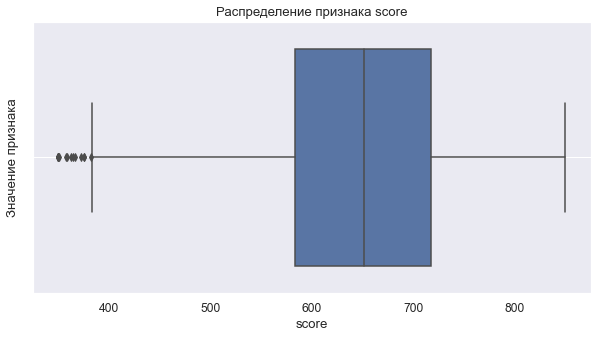

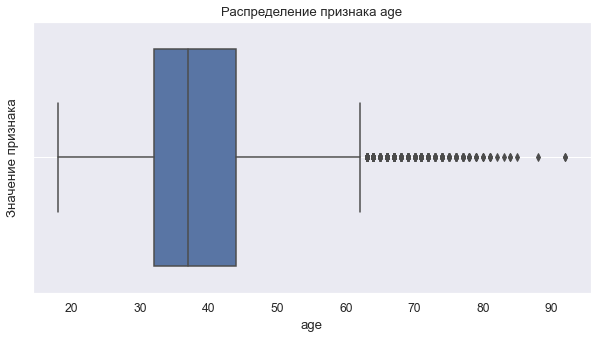

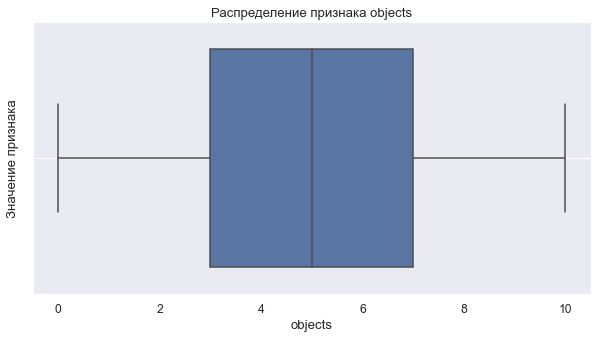

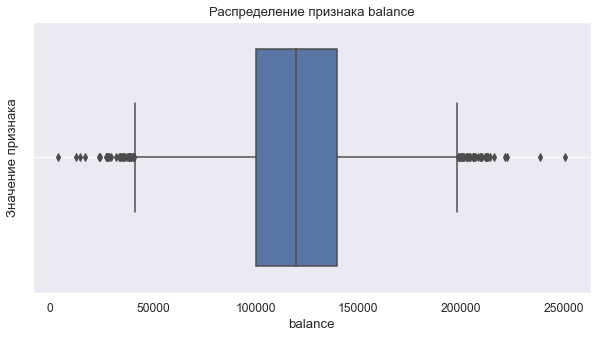

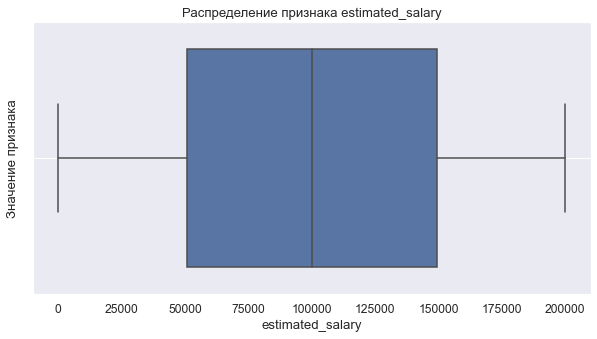

In [15]:
boxplot_columns = ['score',
                'age',
                'objects',
                'balance',
                'estimated_salary']

for col in boxplot_columns:
    fig, ax = plt.subplots(figsize=(10,5))
    b = sns.boxplot(data = df, x = col)
    plt.title("Распределение признака "+col)
    plt.ylabel('Значение признака')
    plt.grid()
    plt.show()

In [16]:
print(np.percentile(df['age'], [90, 95, 99]))

[53. 60. 72.]


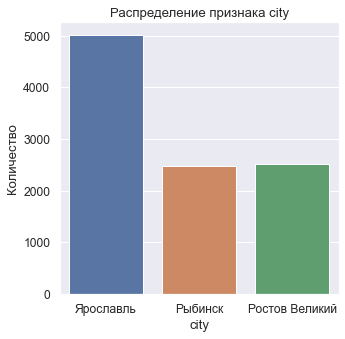

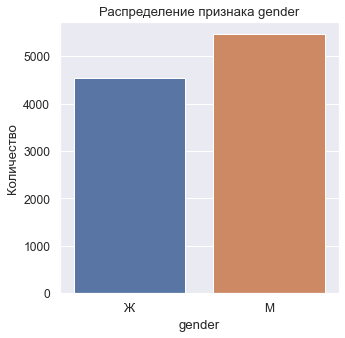

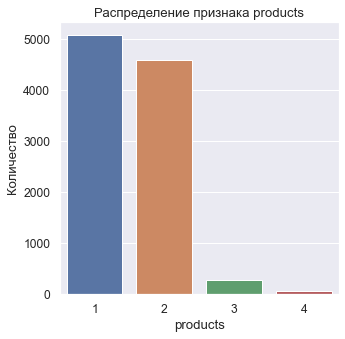

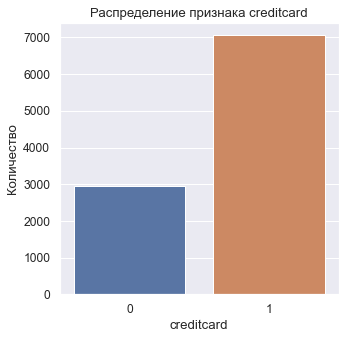

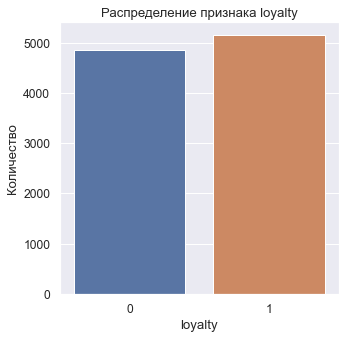

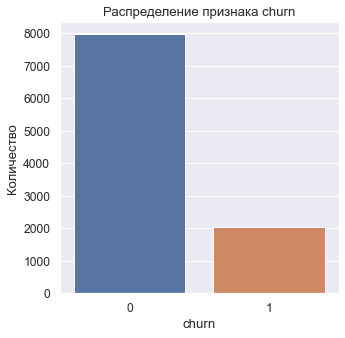

In [17]:
for col in df.drop(['userid'], axis = 1).columns:
    if col not in boxplot_columns:
        plt.figure(figsize=(5, 5))
        sns.countplot(x = df[col],  data = df)
        plt.title('Распределение признака '+ col)
        plt.ylabel('Количество')
        plt.show()

На основании анализа можно составить усреднённый портрет клиента, характерные признаки такого клиента:

- средний кредитный скоринг - 650 баллов;
- возраст от 30 до 45 лет;
- имеет в собственности 5 объектов;
- баланс на счёте в среднем 119,8 тыс. у.е.;
- пользуется в среднем одним-двумя банковскиими продуктами;
- зарплатой около 100,1 тыс. у.е.;
- Половина клиентов из Ярославля, в Рыбинске и Ростове Великом в два раза меньше (логично, учитывая плотность населения);
- женщин среди клиентов немного меньше, чем мужчин;
- кредитная карта есть примерно у 70% клиентов;
- активных клиентов чуть больше половины;
- в отток уходит примерно 20% клиентов.

Исследовав выбросы в данных, можно отметить, что:

- не больше 5% клиентов старше 60 лет;
- мало клиентов, у которых баланс на счете меньше 50 тыс. и больше 200 тыс.у.е.

Изучим теперь распределение признаков клиентов банка в группах по количеству используемых продуктов.

**Выявление особенностей групп клиентов по количеству потребляемых продуктов**

In [18]:
df.groupby('products').mean()

,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
products,,,,,,,,,
1,"15,732,367.9",649.1,39.7,5.0,"119,894.2",0.7,0.5,"99,487.3",0.3
2,"15,734,841.5",652.2,37.8,5.1,"119,660.9",0.7,0.5,"100,452.0",0.1
3,"15,741,816.5",648.1,43.2,5.0,"119,475.7",0.7,0.4,"104,318.1",0.8
4,"15,719,361.3",653.6,45.7,5.3,"122,260.6",0.7,0.5,"104,763.7",1.0


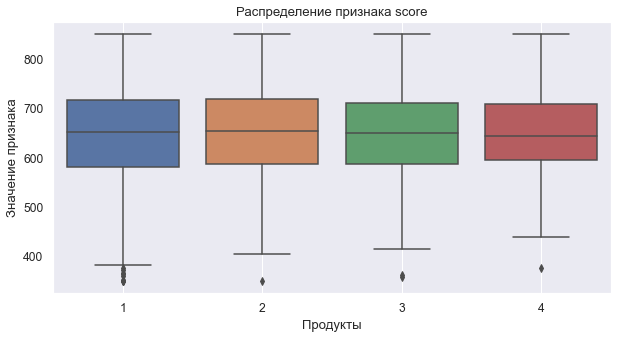

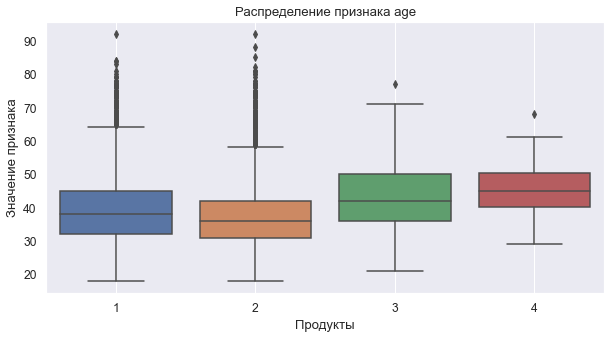

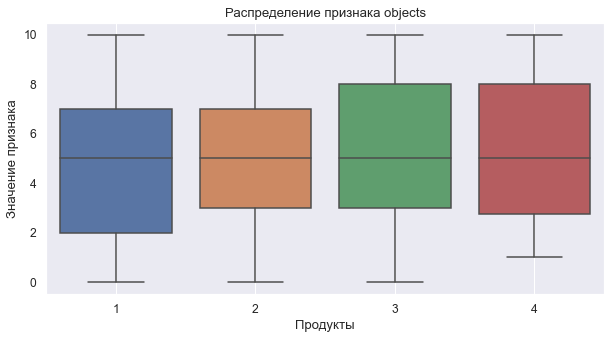

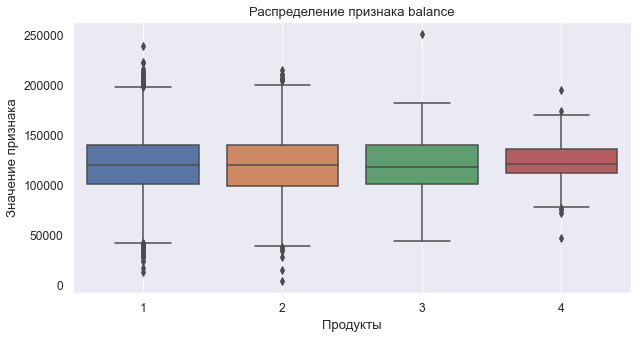

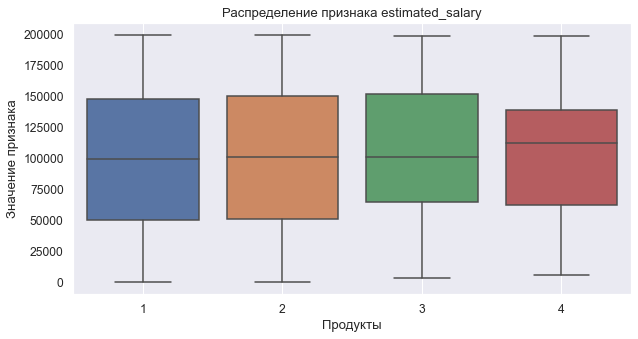

In [19]:
# Построим боксплоты для числовых признаков  в группах по количеству используемых продуктов


for col in boxplot_columns:
    fig, ax = plt.subplots(figsize=(10,5))
    b = sns.boxplot(x='products', y=col, data=df)
    plt.title("Распределение признака "+col)
    plt.xlabel('Продукты')
    plt.ylabel('Значение признака')
    plt.grid()
    plt.show()

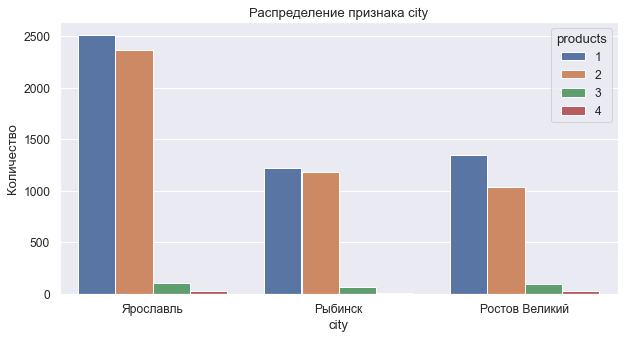

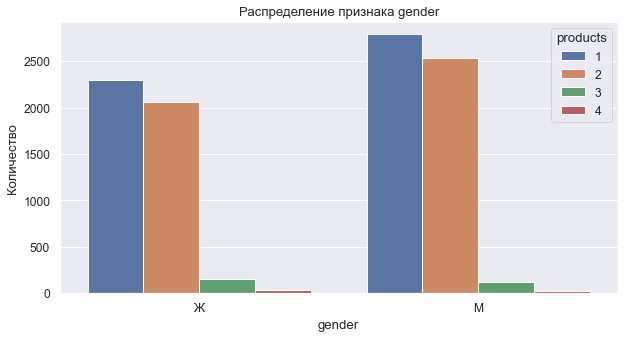

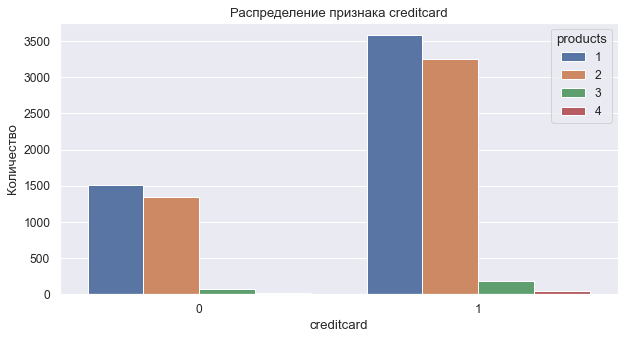

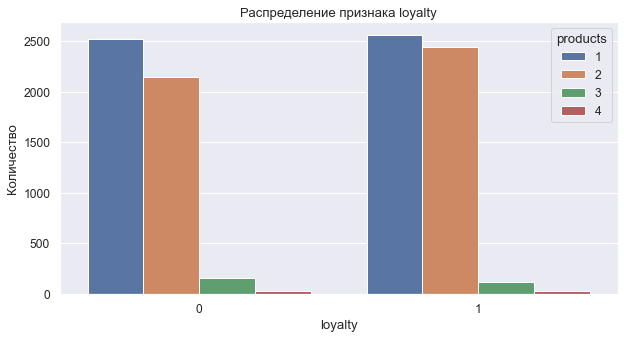

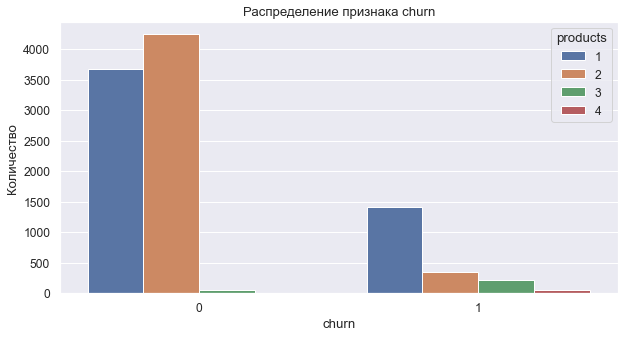

In [20]:
# Построим столбчатые гистограммы для категориальных признаков в группах по количеству используемых продуктов

for col in df.drop(['products','userid'], axis = 1).columns:
    if col not in boxplot_columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(x = df[col], hue = 'products',  data = df)
        plt.title('Распределение признака '+ col)
        plt.ylabel('Количество')
        plt.show()

Анализ особенностей групп клиентов по количеству потребляемых продуктов показал, что:

- скоринговый балл для всех групп имеет нормальное распределение и в среднем составляет 650 баллов, как и для всего датасета;
- распределение возраста клиентов имеет также нормальное распределение. При этом самые молодые клиенты пользуются 2 продуктами, а клиенты старше 45 лет - 4 продуктами;
- нет особенностей по наличию объектов в собственности у клиентов, использующих разное число продуктов. Они имеют в среднем в собственности 5 объектов;
- баланс на счете клиентов в среднем составляет 119,5 тыс.у.е., однако для клиентов, которые пользуются 4 продуктами, средний баланс на счете немного выше и составляет более 122 тыс.у.е;
- зарплата в среднем составляет около 100 тыс.у.е., чуть меньше средняя зарплата у клиентов, которые пользуются одним продуктом;
- в Ярославле наибольшая разница в числе клиентов, которые пользуются 1 либо 2 и 3 или более продуктами;
- распределение по полу примерно одинаковое;
- кредитных карт больше всего у клиентов с 3 и 4 продуктами;
- владельцы трех продуктов чаще уходят из банка, чем те, у кого их один или два, а вот держатели четырех продуктов полностью ушли в группу оттока.


Таким образом, были выявлены несколько определяющих признаков клиентов с бОльшим количеством потребляемых продуктов:

- клиенты в среднем 45 лет;
- баланс на счете больше;
- в основном пользуются кредитными картами;
- лояльность ниже;
- сильно склонны к оттоку.


**Анализ зависимости количества потребляемых продуктов от других признаков**

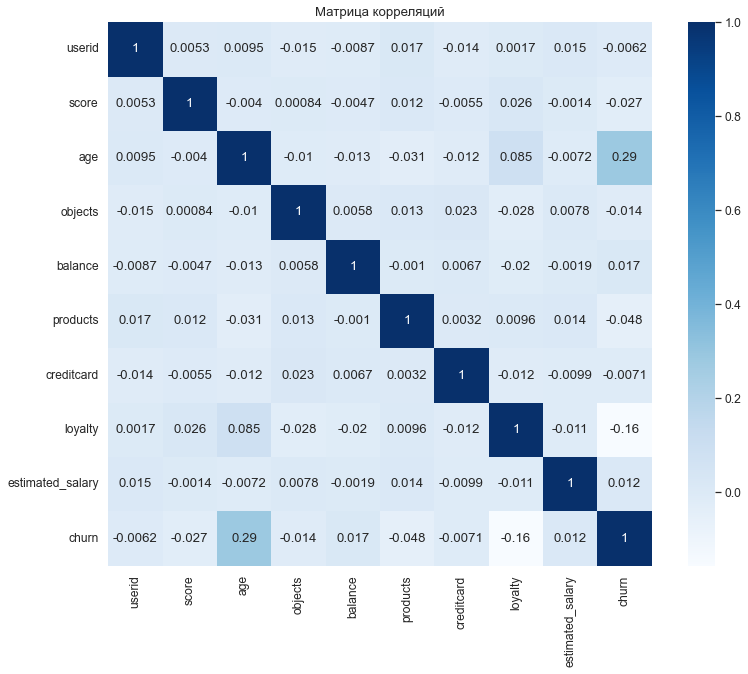

In [21]:
# строим матрицу корреляций 

cm = df.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(cm, annot = True, square = True, cmap = "Blues")
plt.title('Матрица корреляций')
plt.show()

Тепловая карта показала, что на количество продуктов влияют только возраст и отток. В целом можно сказать, что мы имеем довольно слабые признаки. Нет ни одного признака, который коррелировал бы с целевой переменной выше уровня слабой корреляции, в данном случае это не больше 0.29. Следовательно, у нас нет признаков, которые бы сильно влияли на количество продуктов у клиента.


Заменим пропущенные значения в столбце с балансом на счете клиента на отрицательное число, чтобы дальше было удобно работать с данными. Замена на медиану или среднее может сильно исказить результаты.

In [22]:
df = df.fillna('-1')

**Вывод**

На основании анализа можно составить усреднённый портрет клиента, характерные признаки такого клиента:

- средний кредитный скоринг - 650 баллов;
- возраст от 30 до 45 лет;
- имеет в собственности 5 объектов;
- баланс на счёте в среднем 119,8 тыс. у.е.;
- пользуется в среднем одним-двумя банковскиими продуктами;
- зарплатой около 100,1 тыс. у.е.;
- Половина клиентов из Ярославля, в Рыбинске и Ростове Великом в два раза меньше (логично, учитывая плотность населения);
- женщин среди клиентов немного меньше, чем мужчин;
- кредитная карта есть примерно у 70% клиентов;
- активных клиентов чуть больше половины;
- в отток уходит примерно 20% клиентов.

75% клиентов пользуются не менее чем 2 продуктами, но есть и такие клиенты, которые пользуются 4 продуктами. При этом в среднем всё же клиенты банка пользуются 1 продуктом.

Таким образом, были выявлены несколько определяющих признаков клиентов с бОльшим количеством потребляемых продуктов:

- клиенты в среднем 45 лет;
- баланс на счете больше;
- в основном пользуются кредитными картами;
- лояльность ниже;
- сильно склонны к оттоку.

## Сегментация клиентов банка по потреблению

Приведем категориальные значения в столбцах gender и city к числовым для выделения сегментов. 

In [23]:
# gender
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])

# city
df['city'] = encoder.fit_transform(df['city'])
df.head()


,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,2,0,42,2,-1,1,1,1,"101,348.9",1
1,15690047,608,1,0,41,1,"83,807.9",1,0,1,"112,542.6",0
2,15662040,502,2,0,42,8,"159,660.8",3,1,0,"113,931.6",1
3,15744090,699,2,0,39,1,-1,2,0,0,"93,826.6",0
4,15780624,850,1,0,43,2,"125,510.8",1,1,1,"79,084.1",0


Удалим из датасета клиентов с пропусками в столбце баланса, т.к. процент пропусков велик (36%), фиктивная переменная взамен пропущенных в любом случае приведут к искажению результатов. Также удалим столбец userid, числовые значения которого также могут сильно исказить результаты.

In [24]:
# создаём новый датасет
df_cluster = df.query('balance != "-1"').drop('userid', axis=1)
df_cluster.head()

,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
1,608,1,0,41,1,"83,807.9",1,0,1,"112,542.6",0
2,502,2,0,42,8,"159,660.8",3,1,0,"113,931.6",1
4,850,1,0,43,2,"125,510.8",1,1,1,"79,084.1",0
5,645,1,1,44,8,"113,755.8",2,1,0,"149,756.7",1
7,376,0,0,29,4,"115,046.7",4,1,0,"119,346.9",1


Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [25]:
#Cтандартизируем данные
scaler = StandardScaler()
X_sc = scaler.fit_transform(df_cluster)


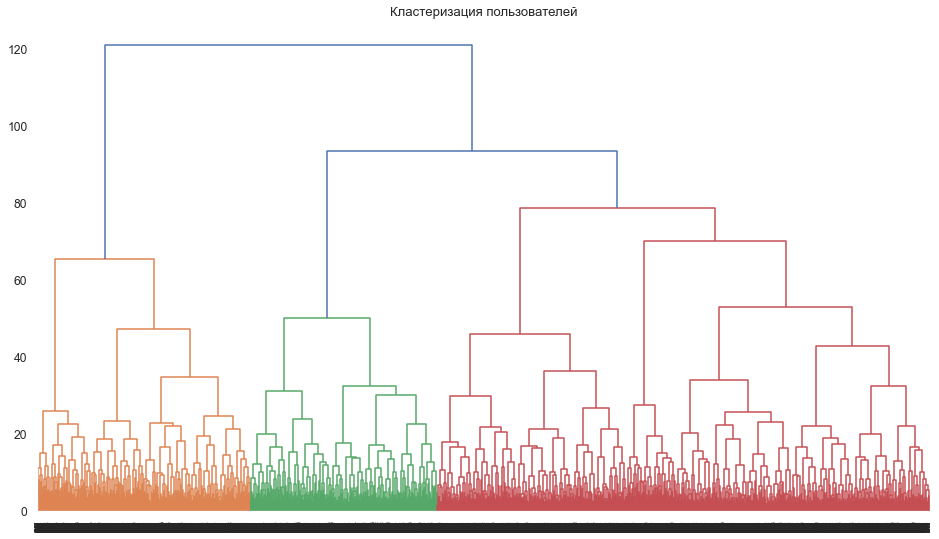

In [26]:
#Сохраним матрицу расстояний
linked = linkage(X_sc, method = 'ward')

#Построим дендрограмму
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Согласно дендрограмме оптимально создание 3 кластеров, но 1 из них потенциально можно разделить еще на несколько.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров возьмем 4.

In [27]:
# задаём число кластеров, равное 4
km = KMeans(n_clusters=4, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc)
labels

array([3, 2, 1, ..., 1, 2, 0])

In [28]:
# #Добавим столбец с номерами кластеров в исходный датафрейм
df_cluster['cluster'] = labels

In [29]:
#Выведем средние значения признаков для кластеров
df_cluster.groupby('cluster').mean()

,score,city,gender,age,objects,products,creditcard,loyalty,estimated_salary,churn
cluster,,,,,,,,,,
0,648.5,1.1,0.6,35.6,5.2,1.4,1.0,0.0,"101,908.5",0.0
1,655.1,1.1,0.6,38.6,4.9,1.4,1.0,1.0,"99,149.5",0.0
2,645.7,0.8,0.4,45.0,5.0,1.5,0.7,0.4,"101,333.3",1.0
3,654.4,1.1,0.6,37.6,4.8,1.4,0.0,0.6,"100,897.1",0.0


In [30]:
# смотрим средние значения для каждого из продуктов
df_cluster.groupby(['products']).mean()

,score,city,gender,age,objects,creditcard,loyalty,estimated_salary,churn,cluster
products,,,,,,,,,,
1,650.3,1.1,0.6,39.4,5.0,0.7,0.5,"99,696.0",0.3,1.5
2,653.1,0.8,0.5,38.1,5.0,0.7,0.5,"102,288.6",0.1,1.4
3,645.5,0.7,0.4,44.0,5.1,0.7,0.4,"107,300.1",0.9,1.9
4,659.0,0.8,0.3,45.0,5.3,0.7,0.5,"101,487.7",1.0,2.0


Клиенты с одним и двумя продуктами попали в основном в первый кластер, с тремя и четырьмя продуктами - во второй.

Для анализа распределения признаков кластеров построим:

столбчатые диаграммы для бинарных значений признаков,
боксплоты для непрерывных переменных.

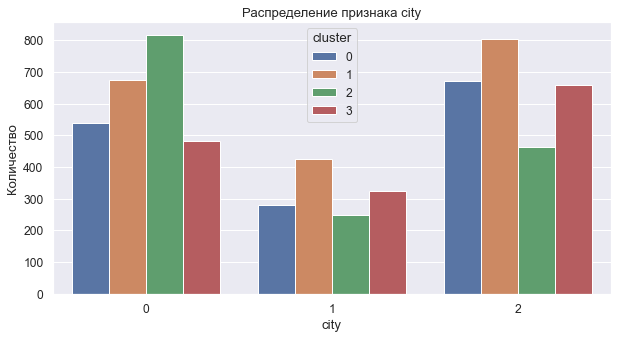

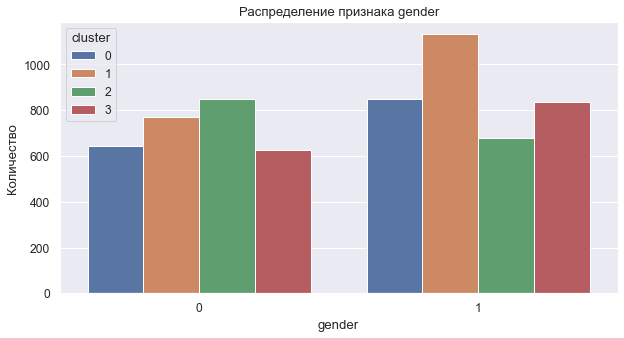

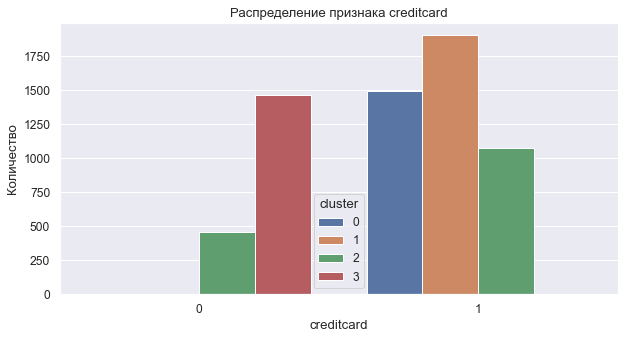

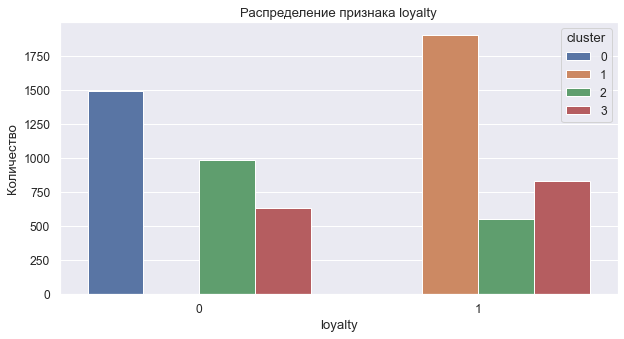

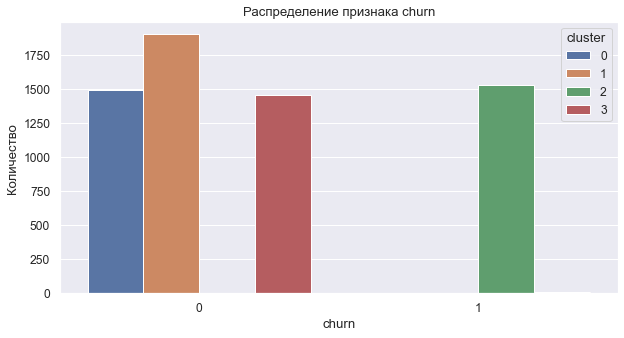

In [31]:
for col in df_cluster.drop(['products', 'cluster'], axis = 1).columns:
    if col not in boxplot_columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(x = df_cluster[col], hue = 'cluster',  data = df_cluster)
        plt.title('Распределение признака '+ col)
        plt.ylabel('Количество')
        plt.show()

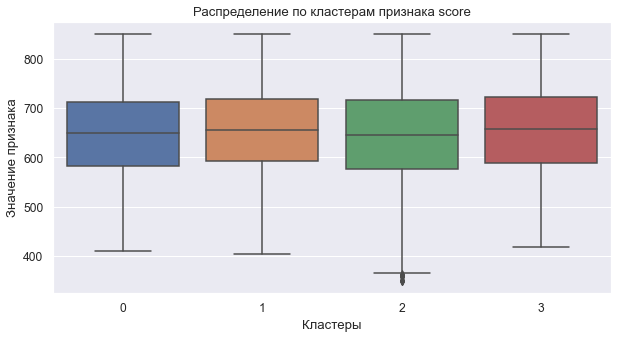

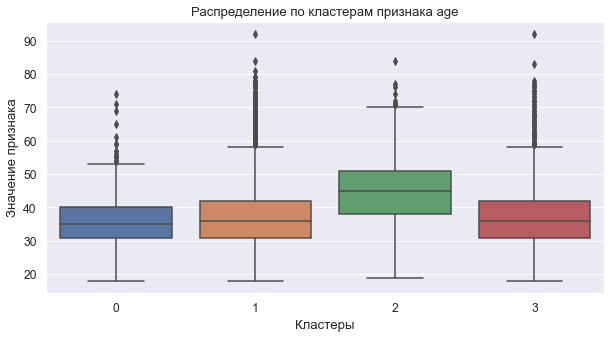

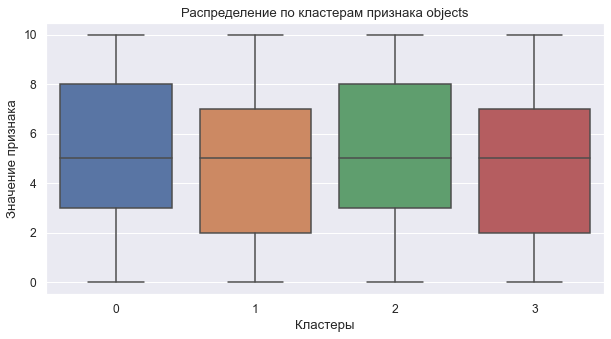

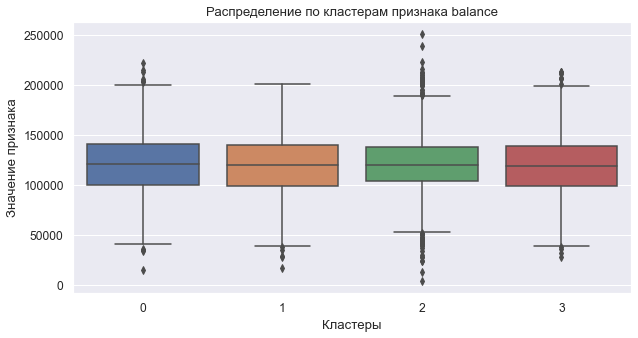

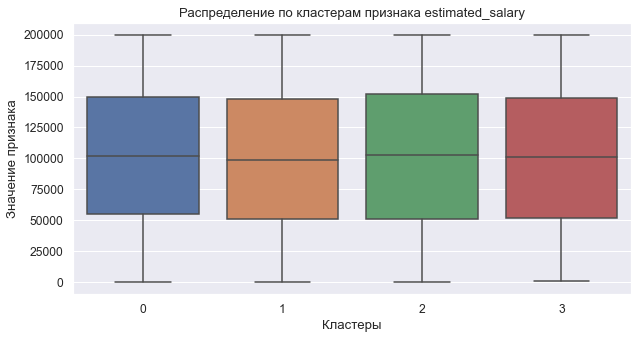

In [32]:
for col in boxplot_columns:
    plt.figure(figsize=(10, 5))
    plt.title("Распределение по кластерам признака "+col)
    sns.boxplot(x='cluster',y=col, data=df_cluster)
    plt.xlabel('Кластеры')
    plt.ylabel('Значение признака')
    plt.show()

По результатам сегментации киентов по количеству потребляемых продуктов выделяются:

- возраст - он находится в среднем на уровне 45 лет для владельцев 3-4 продуктов, что выше на 5-7 лет, чем у остальных; 
- наличие кредитных карт - больше половины клиентов с 3-4 продуктами, пользуются кредитными картами;
- лояльность - ниже у владельцев бОльшего количества продуктов; 
- показатель оттока - все из второго кластера (в основном с 3-4 продуктами) находятся в оттоке.



**Вывод**

Для выделения сегментов клиентов банка банка "Метанпром" по количеству потребляемых продуктов использовали алгоритм K-Means.

Кластеризация позволила выделить 4 сегмента. Сегменты различаются:

- возрастом; 
- наличием кредитных карт у клиентов;
- лояльностью; 
- показателем оттока.



## Проверка статистических гипотез

Проверим гипотезы с помощью t-теста:

1. Гипотеза о равенстве среднего дохода клиентов, которые пользуются двумя продуктами банка, и клиентов, которые пользуются одним. 

2. Гипотеза о разнице в количестве баллов кредитного скоринга, которые пользуются тремя продуктами банка, и теми, которые пользуются одним.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
    \text{Нулевая гипотеза: Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, не различается.}\\
    \text{Альтернативная гипотеза: Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, различается.}
 \end{cases}
\end{equation*}$


Уровень значимости: $\alpha = 0.05$

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Перед проверкой гипотезы сравним размеры выборок:

In [33]:
prod_1_salary = df[df['products']==1]['estimated_salary']
prod_2_salary = df[df['products']==2]['estimated_salary']

print('Количество клиентов, которые ползуются одним продуктом:', prod_1_salary.count())
print('Количество клиентов, которые ползуются двумя продуктом:', prod_2_salary.count())

Количество клиентов, которые ползуются одним продуктом: 5084
Количество клиентов, которые ползуются двумя продуктом: 4590


Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез применим поправку Бонферрони

In [34]:
results = st.ttest_ind(prod_1_salary, prod_2_salary, equal_var=False)

alpha=0.05
print('p-значение: ', results.pvalue)

bonferroni_alpha = alpha / 2

if (results.pvalue < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


*Вывод*: p-value получилось больше выбранного уровня α=0.05 . На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, не различается.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
    \text{Нулевая гипотеза: Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.}\\
    \text{Альтернативная гипотеза: Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, различаются.}
 \end{cases}
\end{equation*}$


Уровень значимости: $\alpha = 0.05$

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [35]:
prod_1_score = df[df['products']==1]['score']
prod_2_score = df[df['products']==2]['score']

results = st.ttest_ind(prod_1_score, prod_2_score, equal_var=False)

alpha=0.05

bonferroni_alpha = alpha / 2

print('p-значение: ', results.pvalue)

if (results.pvalue < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.11889293846062188
Не получилось отвергнуть нулевую гипотезу


*Вывод*: p-value получилось больше выбранного уровня α=0.05. На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

**Вывод**

С помощью ttest из библиотеки scipy были проведены проверки гипотез:
1. Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, не различается.
2. Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

Проверка показала, что:
1. На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, не различается.
2. На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

## Общие выводы

В проектной работе был проведен анализ данных о клиентах банка «Метанпром» и сегментация клиентов по потреблению.

На основании анализа можно составить усреднённый портрет клиента, характерные признаки такого клиента:

- средний кредитный скоринг - 650 баллов;
- возраст от 30 до 45 лет;
- имеет в собственности 5 объектов;
- баланс на счёте в среднем 119,8 тыс. у.е.;
- пользуется в среднем одним-двумя банковскиими продуктами;
- зарплатой около 100,1 тыс. у.е.;
- Половина клиентов из Ярославля, в Рыбинске и Ростове Великом в два раза меньше (логично, учитывая плотность населения);
- женщин среди клиентов немного меньше, чем мужчин;
- кредитная карта есть примерно у 70% клиентов;
- активных клиентов чуть больше половины;
- в отток уходит примерно 20% клиентов.

Об использовании количества продуктов клиента мы узнали, что 75% клиентов пользуются не менее чем 2 продуктами. Приэтом в среднем всё же клиенты банка пользуются 1 продуктом.

Анализ особенностей групп клиентов позволил выявить несколько определяющих признаков клиентов с бОльшим количеством потребляемых продуктов:

- клиентам в среднем 45 лет;
- баланс на счете больше среднего;
- в основном пользуются кредитными картами;
- лояльность ниже;
- сильно склонны к оттоку.

Для выделения сегментов клиентов банка банка "Метанпром" по количеству потребляемых продуктов в работе был использован алгоритм K-Means.


С помощью ttest из библиотеки scipy были проведены проверки двух гипотез, в результате:

1. На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Cредний доход клиентов, которые пользуются одним продуктом и теми, которые пользуются двумя продуктами, не различается.
2. На основе имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу. Средние показатели кредитного скоринга между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

*На основании проведенного анализа и сегментации пользователей рекомендуем:*

1. предлагать клиентам старше 45 лет новые продукты, например, индивидульные инвестиционные программы, программы страхования, поскольку, как правило, это уже состоявшиеся люди со стабильным и хорошим заработком и в среднем пользуются бОльшим количеством продуктов.

2. предлагать комплексные продукты клиентам, т.к. клиенты, пользующиеся 3-4 банковскими продуктами попадают в отток и менее лояльны к банку. Вероятно, в других банках уже существуют комлексные продукты клиентам, поэтому они и уходят. Например, можно предлагать бесплатное обслуживание кредитной карты для клиентов, у которых уже есть вклады или дебетовая карта в банке, или кредит с хорошей историей платежей.

3. провести анализ конкурентов банка на наличие более выгодных условий для клиентов, которые пользуются большим количеством продуктов. Для этого стоит изучить дополнительные продукты банков: страхование, инвестиционные предложения, пенсионные программы и условия по комлексным программам.

